<a href="https://colab.research.google.com/github/Kowsar156/Deep-Learning-at-fast.ai/blob/main/Is_it_a_bird%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 49.7 MB/s eta 0:00:00


The basic steps we'll take are:

Use DuckDuckGo to search for images of "bird photos"

Use DuckDuckGo to search for images of "forest photos"

Fine-tune a pretrained neural network to recognise these two groups

Try running this model on a picture of a bird and see if it works.

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [ ]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg'

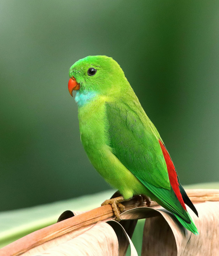

In [ ]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'forest photos'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


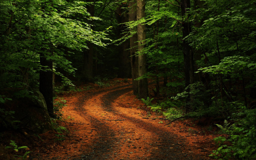

In [ ]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [ ]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


Step 2: Train our model

Removing photos not downloaded correctly

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

15

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


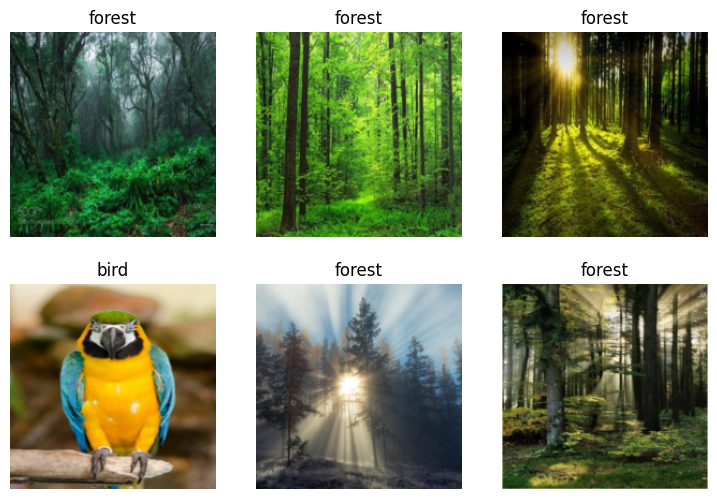

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the DataBlock parameters means:

blocks=(ImageBlock, CategoryBlock),
The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

get_items=get_image_files,
To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).

splitter=RandomSplitter(valid_pct=0.2, seed=42),
Split the data into training and validation sets randomly, using 20% of the data for the validation set.

get_y=parent_label,
The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).

item_tfms=[Resize(192, method='squish')]
Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is resnet18. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
from PIL import Image
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.467750,0.002166,0.000000,01:16


epoch,train_loss,valid_loss,error_rate,time
0,0.007832,0.000338,0.000000,01:50
1,0.005102,0.000181,0.000000,01:51
2,0.004393,0.000677,0.000000,01:52


"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the pretrained model), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in imagenet, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the free fast.ai course.

Step 3: Use our model

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
